# Xarray/Zarr/Icechunk on S3

You will need to run this notebook in a `conda` environment created from `environment.yml`.

In [1]:
import zarr
from icechunk import IcechunkStore, StorageConfig

## Create a new Zarr store backed by Icechunk

This example uses a S3 store

In [2]:
s3_storage = StorageConfig.s3_from_env(
    bucket="icechunk-test", prefix="oscar-demo-repository"
)

In [3]:
store = IcechunkStore.create(
    storage=s3_storage,
    mode="w",
)

## Real data

In [4]:
import xarray as xr

In [5]:
import fsspec

fs = fsspec.filesystem("s3")

In [7]:
oscar = xr.open_dataset(
    fs.open("s3://earthmover-sample-data/netcdf/oscar_vel2018.nc"),
    chunks={},
    engine="h5netcdf",
)
oscar

<xarray.Dataset> Size: 1GB
Dimensions:    (depth: 1, latitude: 481, longitude: 1201, time: 72, year: 72)
Coordinates:
  * depth      (depth) float32 4B 15.0
  * latitude   (latitude) float64 4kB 80.0 79.67 79.33 ... -79.33 -79.67 -80.0
  * longitude  (longitude) float64 10kB 20.0 20.33 20.67 ... 419.3 419.7 420.0
  * time       (time) datetime64[ns] 576B 2018-01-01 2018-01-06 ... 2018-12-26
  * year       (year) float32 288B 2.018e+03 2.018e+03 ... 2.019e+03 2.019e+03
Data variables:
    u          (time, depth, latitude, longitude) float64 333MB dask.array<chunksize=(72, 1, 481, 1201), meta=np.ndarray>
    um         (time, depth, latitude, longitude) float64 333MB dask.array<chunksize=(72, 1, 481, 1201), meta=np.ndarray>
    v          (time, depth, latitude, longitude) float64 333MB dask.array<chunksize=(72, 1, 481, 1201), meta=np.ndarray>
    vm         (time, depth, latitude, longitude) float64 333MB dask.array<chunksize=(72, 1, 481, 1201), meta=np.ndarray>
Attributes: (12/17)
    VARIABLE:       Ocean Surface Currents
    DATATYPE:       1/72 YEAR Interval
    DATASUBTYPE:    unfiltered
    GEORANGE:       20 to 420 -80 to 80
    PERIOD:         Jan.01,2018 to Dec.26,2018
    year:           2018
    ...             ...
    company:        Earth & Space Research, Seattle, WA
    reference:      Bonjean F. and G.S.E. Lagerloef, 2002 ,Diagnostic model a...
    note1:          Maximum Mask velocity is the geostrophic component at all...
    note2:          Longitude extends from 20 E to 420 E to avoid a break in ...
    history:        Wed Sep 18 14:18:38 2024: ncks -4 -o oscar_vel2018.nc4 os...
    NCO:            netCDF Operators version 5.2.8 (Homepage = http://nco.sf....

## Write to icechunk

In [8]:
group = zarr.group(store=store, overwrite=True)
group

Group(_async_group=<AsyncGroup <icechunk.IcechunkStore object at 0x7efd807b8920>>)

In [9]:
import time

for var in oscar:
    print(var)
    tic = time.time()
    group.create_array(
        name=var,
        shape=oscar[var].shape,
        chunk_shape=(1, 1, 481, 1201),
        fill_value=-1234567,
        dtype=oscar[var].dtype,
        data=oscar[var],
        exists_ok=True,
    )
    print(store.commit(f"wrote {var}"))
    print(f"committed; {time.time() - tic} seconds")

u
D2YNJWWTKW6DY8ECPJZG
committed; 43.68043661117554 seconds
um
V0RSK39P1EXKB37F6Z10
committed; 44.08490180969238 seconds
v
JNDCHT5MF2MWRHYY8Q1G
committed; 61.78669619560242 seconds
vm
GAKXY70VJ2NQ3ANMEE10
committed; 55.72252893447876 seconds


In [14]:
store.ancestry()

[('GAKXY70VJ2NQ3ANMEE10',
  'wrote vm',
  datetime.datetime(2024, 9, 27, 1, 44, 32, 21912, tzinfo=datetime.timezone.utc)),
 ('JNDCHT5MF2MWRHYY8Q1G',
  'wrote v',
  datetime.datetime(2024, 9, 27, 1, 43, 36, 291827, tzinfo=datetime.timezone.utc)),
 ('V0RSK39P1EXKB37F6Z10',
  'wrote um',
  datetime.datetime(2024, 9, 27, 1, 42, 34, 501948, tzinfo=datetime.timezone.utc)),
 ('D2YNJWWTKW6DY8ECPJZG',
  'wrote u',
  datetime.datetime(2024, 9, 27, 1, 41, 50, 428929, tzinfo=datetime.timezone.utc)),
 ('7YA9K51RW5N422R8YAPG',
  'Repository initialized',
  datetime.datetime(2024, 9, 27, 1, 40, 21, 969915, tzinfo=datetime.timezone.utc))]

## Open store

In [3]:
import zarr
from icechunk import IcechunkStore, StorageConfig

# TODO: catalog will handle this
s3_storage = StorageConfig.s3_from_env(
    bucket="icechunk-test", prefix="oscar-demo-repository"
)

In [4]:
store = IcechunkStore.open_existing(
    storage=s3_storage,
    mode="r",
)
store

Look at history

In [5]:
store.ancestry()

[('GAKXY70VJ2NQ3ANMEE10',
  'wrote vm',
  datetime.datetime(2024, 9, 27, 1, 44, 32, 21912, tzinfo=datetime.timezone.utc)),
 ('JNDCHT5MF2MWRHYY8Q1G',
  'wrote v',
  datetime.datetime(2024, 9, 27, 1, 43, 36, 291827, tzinfo=datetime.timezone.utc)),
 ('V0RSK39P1EXKB37F6Z10',
  'wrote um',
  datetime.datetime(2024, 9, 27, 1, 42, 34, 501948, tzinfo=datetime.timezone.utc)),
 ('D2YNJWWTKW6DY8ECPJZG',
  'wrote u',
  datetime.datetime(2024, 9, 27, 1, 41, 50, 428929, tzinfo=datetime.timezone.utc)),
 ('7YA9K51RW5N422R8YAPG',
  'Repository initialized',
  datetime.datetime(2024, 9, 27, 1, 40, 21, 969915, tzinfo=datetime.timezone.utc))]

In [7]:
root_group = zarr.open_group(store=store)

In [8]:
root_group.members()

(('um',
  <Array <icechunk.IcechunkStore object at 0x7fc0580983e0>/um shape=(72, 1, 481, 1201) dtype=float64>),
 ('u',
  <Array <icechunk.IcechunkStore object at 0x7fc0580983e0>/u shape=(72, 1, 481, 1201) dtype=float64>),
 ('v',
  <Array <icechunk.IcechunkStore object at 0x7fc0580983e0>/v shape=(72, 1, 481, 1201) dtype=float64>),
 ('vm',
  <Array <icechunk.IcechunkStore object at 0x7fc0580983e0>/vm shape=(72, 1, 481, 1201) dtype=float64>))

In [9]:
root_group.members()

(('v',
  <Array <icechunk.IcechunkStore object at 0x7fc0580983e0>/v shape=(72, 1, 481, 1201) dtype=float64>),
 ('vm',
  <Array <icechunk.IcechunkStore object at 0x7fc0580983e0>/vm shape=(72, 1, 481, 1201) dtype=float64>),
 ('u',
  <Array <icechunk.IcechunkStore object at 0x7fc0580983e0>/u shape=(72, 1, 481, 1201) dtype=float64>),
 ('um',
  <Array <icechunk.IcechunkStore object at 0x7fc0580983e0>/um shape=(72, 1, 481, 1201) dtype=float64>))

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt

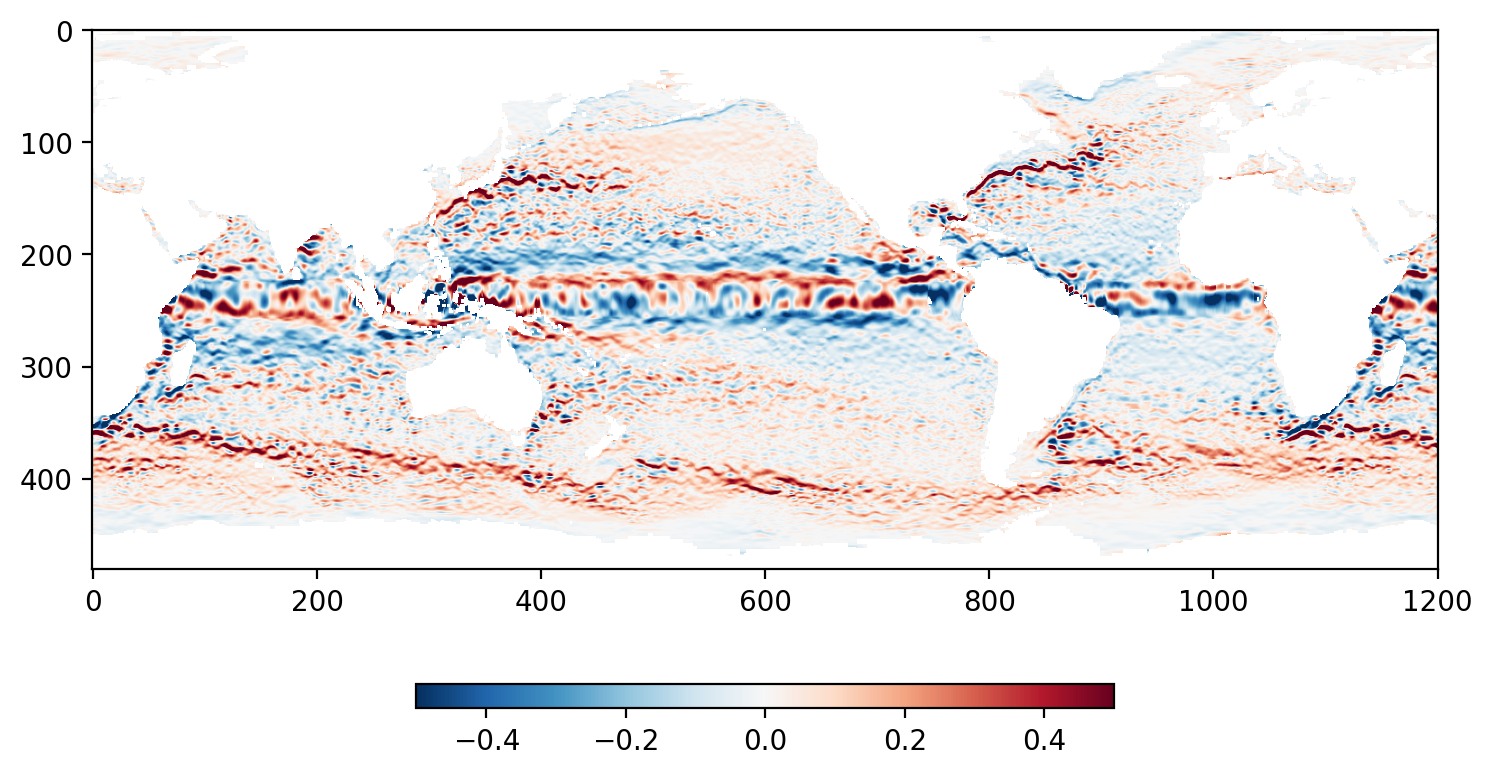

In [36]:
plt.imshow(root_group["u"][20, 0, :, :], cmap=mpl.cm.RdBu_r, vmin=-0.5, vmax=0.5)
plt.gcf().set_size_inches((9, 5))
plt.colorbar(location="bottom", orientation="horizontal", shrink=0.5, aspect=30)